## Explore Enhancers!

This notebook performs downstream analysis using the results from the DNABERT-Enhancer model. In particular, the noteook uses the provided FPR thresholds and classification results to cluster the enhancers into three categories: active, poised enhancers active dissimilar (PEADS), and poised enhancers active similar (peas).

In [1]:
import h5py
from sklearn import metrics
import numpy as np
import matplotlib.pyplot as plt
import os
import csv

Load in the necessary numpy arrays from the evaluation function in `model_src`.

In [77]:
# Load in the Dataset
predictions_dir = "../output/positive_evaulation/"
yground = np.load(predictions_dir + "labels.npy")
ylogits = np.load(predictions_dir + "pred_results.npy")
print(f'There are {yground.shape[0]} positive samples being tested.')
num_samples = yground.shape[0]

print('There are {} poised enhancers'.format(np.count_nonzero(yground == 0))) # num poised
print('There are {} active enhancers'.format(np.count_nonzero(yground == 2))) # num active 

There are 26157 positive samples being tested.
There are 15722 poised enhancers
There are 10435 active enhancers


### Compute Model Results Using FPR Thresholds
The accuracy we received is in line with our expectations considering our large sample of negative samples, and the hypothesized similarity between some poised and active enhancers. 

In [4]:
## Dictionary Store for FPR Thresholds 
## Load this from Eval Results JSON file. 
POISED_THRESHOLDS = {
    0.10 : -0.39354804158210754,
    0.05 : 0.0886303037405014,
    0.03 : 0.34452739357948303,
    0.01 : 0.8528411388397217,
}

ACTIVE_THRESHOLDS = {
    0.10 : -0.5178720355033875,
    0.05 : -0.11259077489376068,
    0.03 : 0.170790046453475952,
    0.01 : 0.7585378885269165,
}

def predict(logits, fpr):
    assert fpr in [0.10, 0.05, 0.03, 0.01]

    pe_thresh = POISED_THRESHOLDS[fpr]
    ae_thresh = ACTIVE_THRESHOLDS[fpr]
    if logits[0] > pe_thresh and logits[2] > ae_thresh:
        return 0 if logits[0] > logits[2] else 2
    elif logits[0] > pe_thresh:
        return 0
    elif logits[2] > ae_thresh:
        return 2
    else:
        return 1

In [5]:
# First Print Out Overall Accuracy
fpr = 0.05
ypreds = np.apply_along_axis(predict, 1, ylogits, fpr)
np.save(os.path.join("../output/positive_evaulation/", "ypreds_fpr05.npy"), ypreds)
usable_ypreds = np.where(ypreds != 1)[0]

fpr_thresh_acc = np.count_nonzero(ypreds == yground) / len(yground)
print(f'Accuracy accounting for FPR: {fpr_thresh_acc}')

valid_pred = ypreds != 1

Accuracy accounting for FPR: 0.5541919944947815


### Plotting AE Scores Across Poised and Active Enhancers

Plotting the AE scores for AEs and PEs that were not clasified as noise. We keep misclasified (between PEs and AEs) due to the high AUC scores and the high similarity between AEs and PEs.

In [110]:
# Plot Function Based on Logits - should see clustering. 
def scale(logits):
    norm = np.linalg.norm(logits, 1)
    return logits / norm

def plot_enhancer(logits, bin_width, enhancer_type, normalized):
    assert enhancer_type in ["Active", "Poised"]

    # Define sampls to bin and count
    bins = np.arange(np.min(logits), np.max(logits), bin_width)
    bin_counts, _ = np.histogram(logits, bins=bins)

    plt.bar(bins[:-1], bin_counts, width=bin_width, align='edge', alpha=0.4, color='blue')
    plt.plot(bins[:-1] + bin_width/2, bin_counts, color='blue')

    plt.xlabel('Acitve Enhancer Score', fontsize=10)
    plt.ylabel(f'Number of {enhancer_type} Enhancers', fontsize=10)
    plt.xticks(fontsize=9.2)
    plt.yticks(fontsize=9.2)
    if normalized:
        plt.title(f'Normalized Active Enhancer Score versus Number of {enhancer_type} Enhancers', fontsize=12)
    else:
        plt.title(f'Unnormalized Active Enhancer Score versus Number of {enhancer_type} Enhancers', fontsize=12)
    plt.show()

import numpy as np
import matplotlib.pyplot as plt

def plot_enhancer_special(logits, bin_width, enhancer_type, normalized):
    assert enhancer_type in ["Active", "Poised"]

    # Define samples to bin and count
    bins = np.arange(np.min(logits), np.max(logits), bin_width)
    bin_counts, _ = np.histogram(logits, bins=bins)

    # Split the bins and bin_counts into two groups: values under 0 and values greater than or equal to 0
    negative_mask = bins[:-1] < 0
    positive_mask = bins[:-1] >= 0

    # Plot the bars for negative values (color: orange)
    plt.bar(bins[:-1][negative_mask], bin_counts[negative_mask], width=bin_width, align='edge', alpha=0.4, color='orange')

    # Plot the bars for non-negative values (color: green)
    plt.bar(bins[:-1][positive_mask], bin_counts[positive_mask], width=bin_width, align='edge', alpha=0.4, color='green')

    # Plot the line plot for negative values (color: orange)
    plt.plot(bins[:-1][negative_mask] + bin_width/2, bin_counts[negative_mask], color='orange')

    # Plot the line plot for non-negative values (color: green)
    plt.plot(bins[:-1][positive_mask] + bin_width/2, bin_counts[positive_mask], color='green')

    plt.xlabel('Active Enhancer Score', fontsize=10)
    plt.ylabel(f'Number of {enhancer_type} Enhancers', fontsize=10)
    plt.xticks(fontsize=9.2)
    plt.yticks(fontsize=9.2)
    if normalized:
        plt.title(f'Normalized Active Enhancer Score versus Number of {enhancer_type} Enhancers', fontsize=12)
    else:
        plt.title(f'Unnormalized Active Enhancer Score versus Number of {enhancer_type} Enhancers', fontsize=12)
    plt.show()

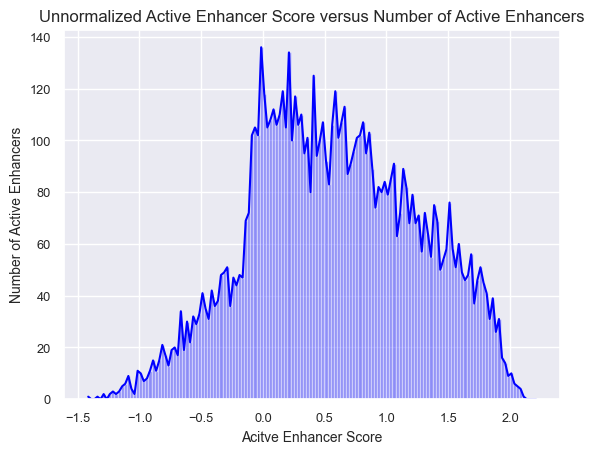

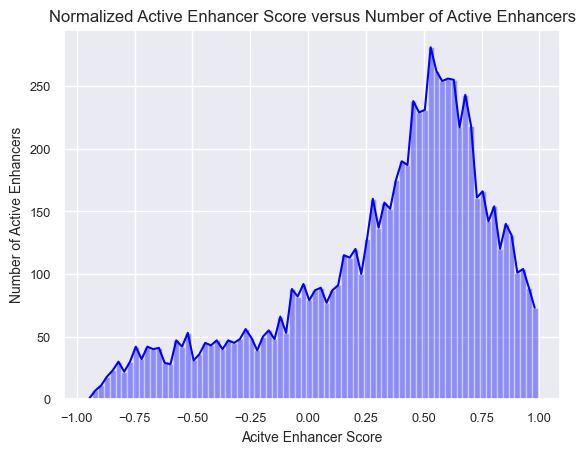

In [111]:
active_condition = np.logical_and(yground == 2, valid_pred)
active_indices = np.where(active_condition)
active_logits = ylogits[active_indices]
plot_enhancer(active_logits[:,2], 0.025, "Active", False)

active_normed = np.apply_along_axis(scale, 1, np.delete(active_logits, 1, axis=1))
plot_enhancer(active_normed[:,1], 0.025, "Active", True)

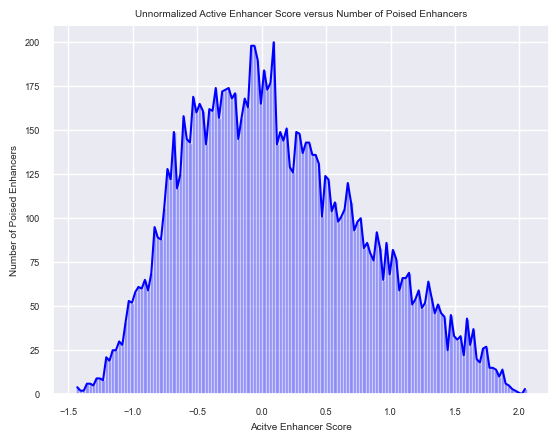

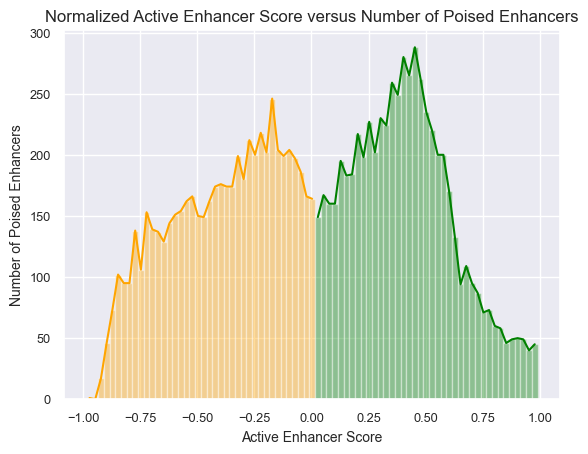

In [108]:
poised_condition = np.logical_and(yground == 0, valid_pred)
poised_indices = np.where(poised_condition)

poised_logits = ylogits[poised_indices]
plot_enhancer(poised_logits[:,2], 0.025, "Poised", False)

poised_normed = np.apply_along_axis(scale, 1, np.delete(poised_logits, 1, axis=1))
plot_enhancer_special(poised_normed[:,1], 0.025, "Poised", True)

Loading in all of the Transcription Factor Binding Sites that We Have in a BED File in addition to our positive BED dataset.

In [10]:
import pandas as pd
from pybedtools import BedTool

bed_file = "../analysis/results/comparison_files/EFO-0003042.TFbinding.bed"
tf_sites = list(BedTool(bed_file))

tfsites = []
with open(bed_file, 'r') as file:
    for line in file:
        info = line.split()
        tfsites.append(info)

df_tfsites = pd.DataFrame(tfsites, columns=['Chrom', 'Start', 'End', 'TF'])

from pybedtools import BedTool

positive_bed = "../data/positive.bed"
positive_list = list(BedTool(positive_bed))


In [11]:
normalized_logits = np.apply_along_axis(scale, 1, np.delete(ylogits, 1, axis=1))
active_i = active_indices[0]
peads_i = np.where(np.logical_and(poised_condition, normalized_logits[:,1] < 0.0))[0]
peas_i = np.where(np.logical_and(poised_condition, normalized_logits[:,1] >= 0.0))[0]

assert(len(active_i) + len(peas_i) + len(peads_i) == np.count_nonzero(ypreds != 1))

active_b = [positive_list[i] for i in active_i]
peads_b = [positive_list[i] for i in peas_i]
peas_b = [positive_list[i] for i in peads_i]

active_bed = BedTool(active_b)
peads_bed = BedTool(peas_b)
peas_bed = BedTool(peads_b)

active_bed.saveas('../data/active.bed')
peads_bed.saveas('../data/peads.bed')
peas_bed.saveas('../data/peas.bed')

num_active = len(active_i)
num_peads = len(peads_i)
num_peas = len(peas_i)

sizes = {"Active" : num_active, "PEADS" : num_peads, "PEAS" : num_peas}

<BedTool(../data/peas.bed)>

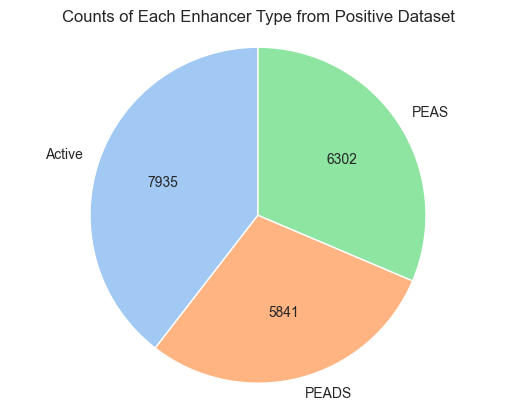

In [90]:
import matplotlib.pyplot as plt
import seaborn as sns

# Data for the three groups
group_names = ['Active', 'PEADS', 'PEAS']
group_counts = [num_active, num_peads, num_peas]

# Use Seaborn's "pastel" palette
sns.set_palette('pastel')

# Create the pie chart
fig, ax = plt.subplots()

def autopct_format(values):
    def my_format(pct):
        total = sum(values)
        val = int(round(pct * total / 100.0))
        return '{v:d}'.format(v=val)
    return my_format

plt.pie(group_counts, labels=group_names, autopct=autopct_format(group_counts), textprops={'fontsize': 10}, startangle=90)

# Add a title
ax.set_title('Counts of Each Enhancer Type from Positive Dataset', fontsize=12)

# Equal aspect ratio ensures that pie is drawn as a circle
ax.axis('equal')

# Display the chart
plt.show()

### Comparing Enhancer Categories' Enrichment Across Different Transcription Factors
Data was acquired from around 80 transcription factors from the ENCODE database. 

In [14]:
## Read in BED Intersect Files
def read_bed(file):
    sites = []
    with open(file, 'r') as file:
        for line in file:
            info = line.split()
            sites.append(info)
    return sites

tfactive = read_bed("../analysis/results/bed_files/tfbind_active.bed")
tfpeads = read_bed("../analysis/results/bed_files/tfbind_peads.bed")
tfpeas = read_bed("../analysis/results/bed_files/tfbind_peas.bed")

print(len(tfactive), len(tfpeads), len(tfpeas))

98615 32622 52326


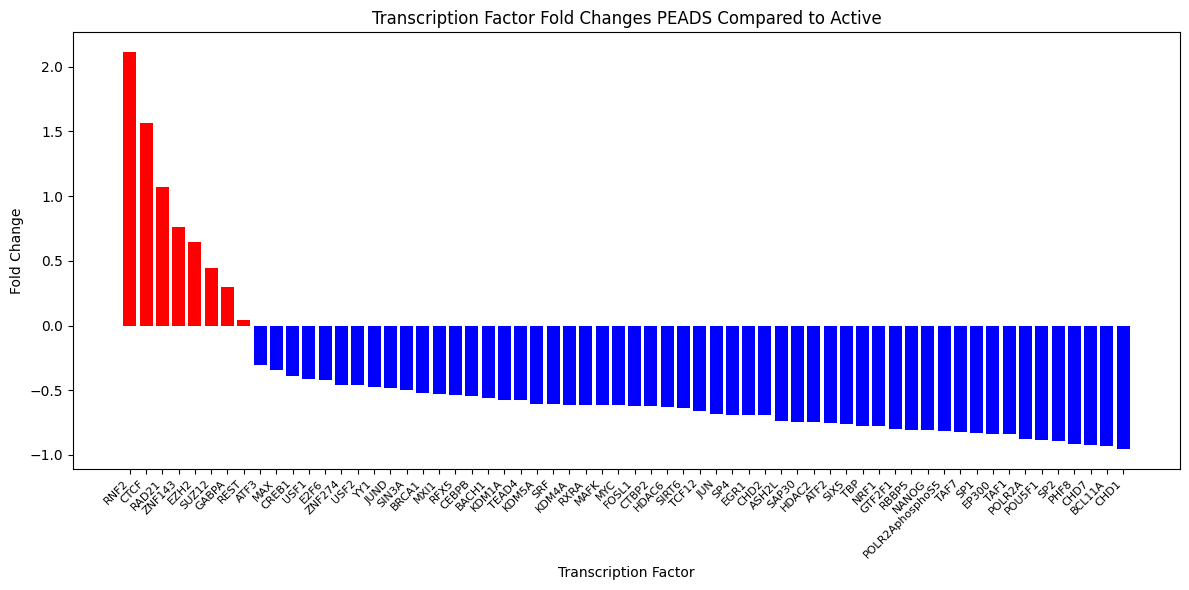

Excluded TF: RNF2, Fold Change: 12.543655249859631


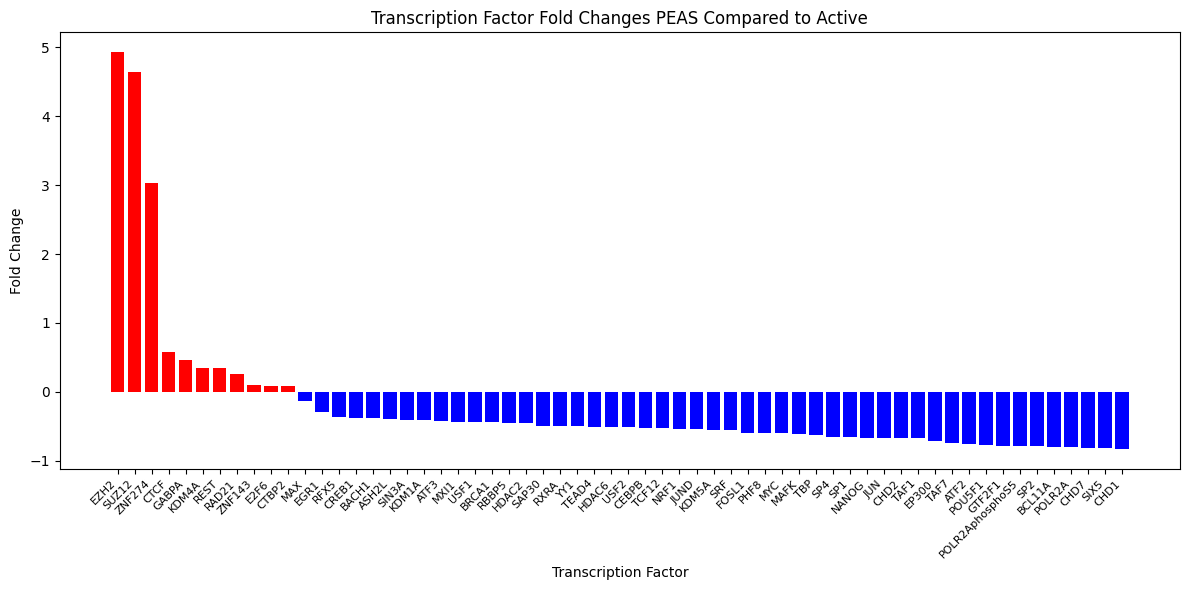

Excluded TF: ZNF274, Fold Change: 6.414788955887021


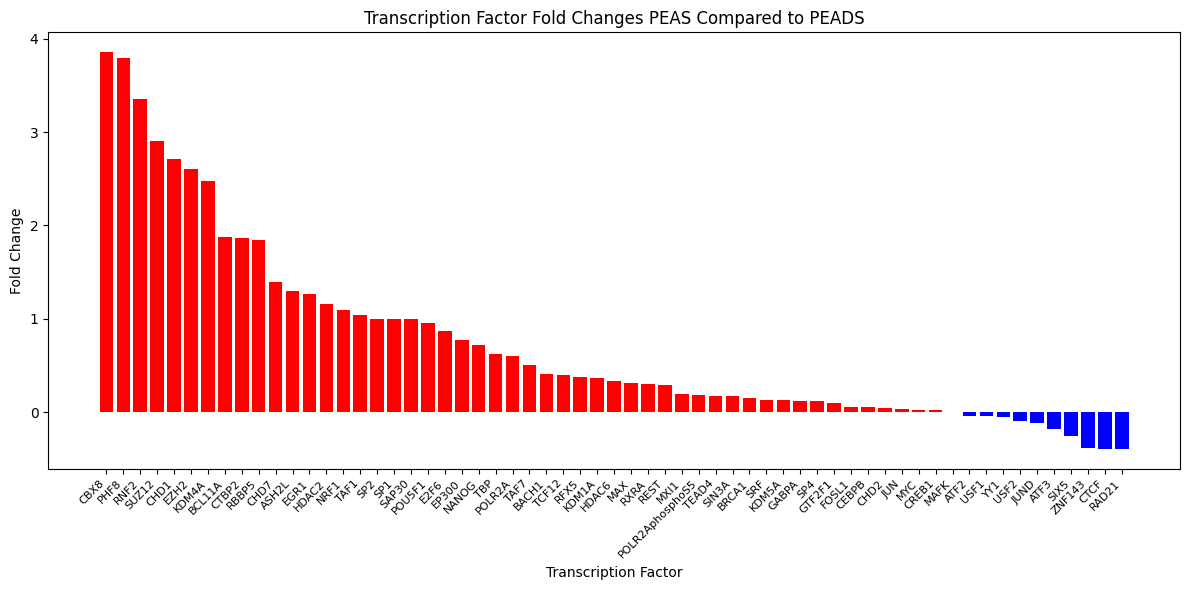

In [23]:
from explore_utils import process_intersection, determine_fold_change, plot_histogram

## Process BEDS
map_active, _ = process_intersection(tfactive)
map_poised, _ = process_intersection(tfpeads)
map_p_to_a, _ = process_intersection(tfpeas)

## Set the Exclusion Bound (i.e. how many standard deviations)
STDEV_EX = 2.5

## Active vs Poised
avsp_map = determine_fold_change(map_active, map_poised, "Active", "PEADS", sizes)
del avsp_map['CBX8']
plot_histogram(avsp_map, "Active", "PEADS", STDEV_EX)

## Active vs PoisedtoActive
avspa_map = determine_fold_change(map_active, map_p_to_a, "Active", "PEAS", sizes)
del avspa_map['CBX8']
plot_histogram(avspa_map, "Active", "PEAS", STDEV_EX)

## Poised vs Poised_to_Active
pvspa_map = determine_fold_change(map_poised, map_p_to_a, "PEADS", "PEAS", sizes)
plot_histogram(pvspa_map, "PEADS", "PEAS", STDEV_EX)

### Correlating Enhancer Categories with Specific Cell Types

In [24]:
# Import Intersect Files generated using Bedtools Intersect
ae_cellx = pd.read_csv("../analysis/results/bed_files/active_cellintersect.bed", sep="\t")
ae_cellx.columns = ['Chrom', 'Start', 'End', 'CellID']

peads_cellx = pd.read_csv("../analysis/results/bed_files/peads_cellintersect.bed", sep="\t")
peads_cellx.columns = ['Chrom', 'Start', 'End', 'CellID']

peas_cellx = pd.read_csv("../analysis/results/bed_files/peas_cellintersect.bed", sep="\t")
peas_cellx.columns = ['Chrom', 'Start', 'End', 'CellID']

# Load in Annotation File on 107 Different Cell Types
cellid_annot = pd.read_csv("../analysis/results/comparison_files/all27ac.cell.anno", sep='\t', index_col=0, header=None)
cellid_annot.columns=['CellID', 'CellName', 'CellCategory', 'StemProg']


#### Plotting Distribution of PEADS and PEAS Across Cell Types

In [40]:
ae_counts = ae_cellx['CellID'].value_counts() / len(ae_cellx.index)
cellid_annot['AEFreq'] = ae_counts

peads_counts = peads_cellx['CellID'].value_counts() / len(peads_cellx.index)
cellid_annot['PEADSFreq'] = peads_counts

peas_counts = peas_cellx['CellID'].value_counts() / len(peas_cellx.index)
cellid_annot['PEASFreq'] = peas_counts


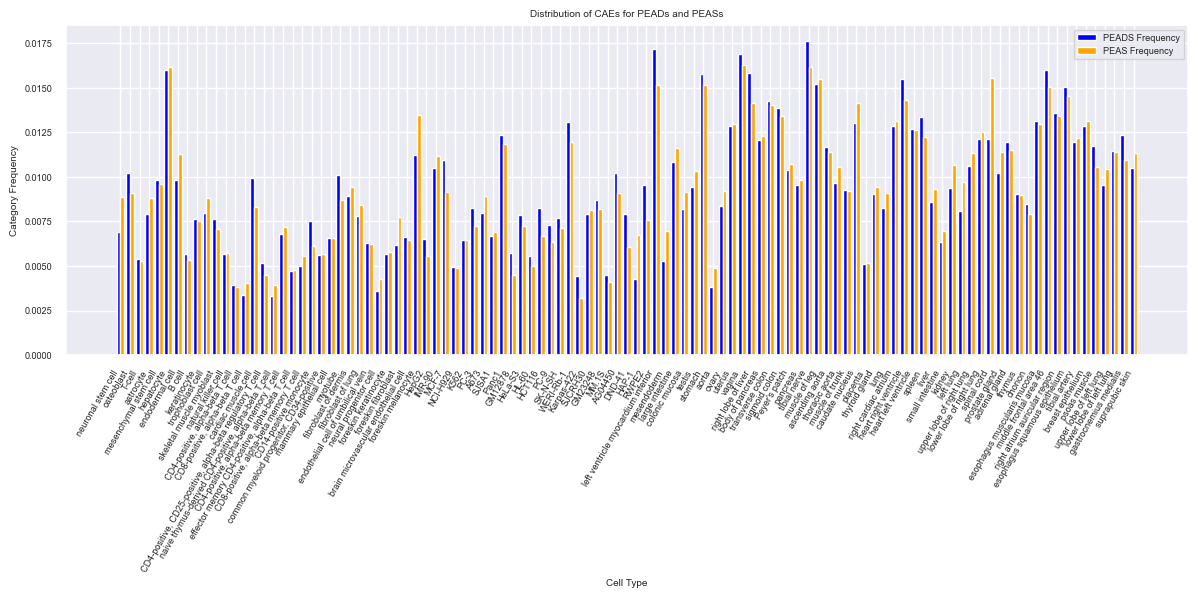

In [62]:
import seaborn as sns
plt.figure(figsize=(12,6))

sns.set(font_scale=0.6)


unique_cells = cellid_annot['CellName']
x = list(range(len(unique_cells)))
bar_width = 0.4

plt.bar(x, cellid_annot['PEADSFreq'], width=bar_width, color='blue', label='PEADS Frequency')
# Plot the bars for DataFrame 2 (orange bars)
plt.bar([i + bar_width for i in x], cellid_annot['PEASFreq'], width=bar_width, color='orange', label='PEAS Frequency')

plt.xticks([i + bar_width / 2 for i in x], unique_cells, rotation=60, ha='right') 
plt.xlabel('Cell Type')
plt.ylabel('Category Frequency')
plt.title('Distribution of CAEs for PEADs and PEASs')
plt.legend()
plt.tight_layout()
plt.show()

In [71]:
def findAttr(cellID, attr):
    value = cellid_annot.loc[cellID]
    return value[attr]

ae_cellx['StemProg'] = ae_cellx['CellID'].map(lambda x: findAttr(x, 'StemProg'), na_action=None)
ae_stemprog_counts = ae_cellx['StemProg'].value_counts() / len(ae_cellx.index)

peads_cellx['StemProg'] = peads_cellx['CellID'].map(lambda x: findAttr(x, 'StemProg'), na_action=None)
peads_stemprog_counts = peads_cellx['StemProg'].value_counts() / len(peads_cellx.index)

peas_cellx['StemProg'] = peas_cellx['CellID'].map(lambda x: findAttr(x, 'StemProg'), na_action=None)
peas_stemprog_counts = peas_cellx['StemProg'].value_counts() / len(peas_cellx.index)

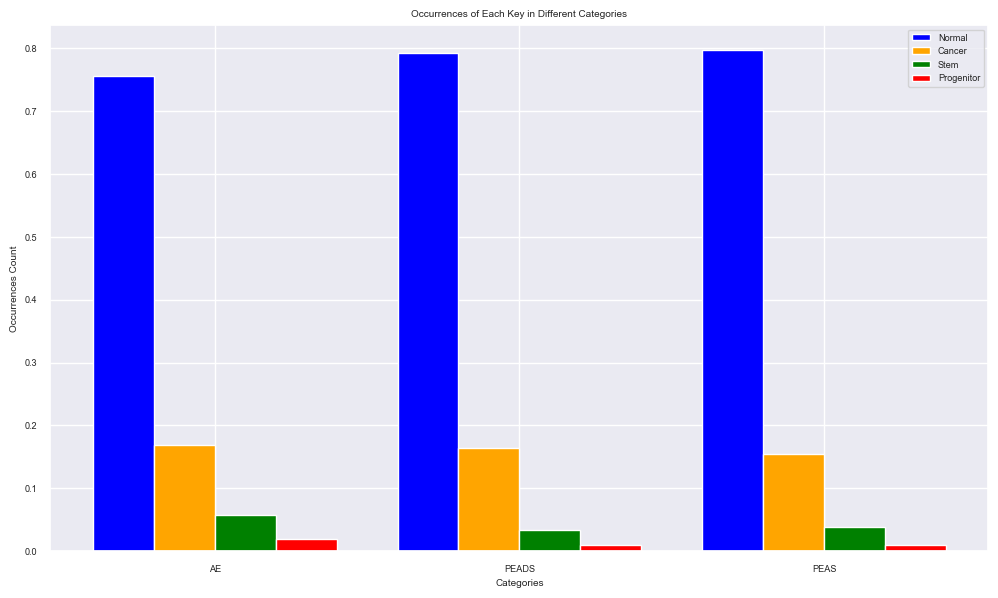

In [72]:
counts = [ae_stemprog_counts, peads_stemprog_counts, peas_stemprog_counts]
values_normal = [count['normal'] for count in counts]
values_cancer = [count['cancer'] for count in counts]
values_stem = [count['stem'] for count in counts]
values_progenitor = [count['progenitor'] for count in counts]

# Get the unique categories for the x-axis labels
categories = ['AE', 'PEADS', 'PEAS']

# Set the width of the bars
bar_width = 0.2

# Set the positions for the bars on the x-axis
x_normal = range(len(categories))
x_cancer = [i + bar_width for i in x_normal]
x_stem = [i + bar_width*2 for i in x_normal]
x_progenitor = [i + bar_width*3 for i in x_normal]

# Create the bar chart
plt.figure(figsize=(10, 6))
plt.bar(x_normal, values_normal, width=bar_width, color='blue', label='Normal')
plt.bar(x_cancer, values_cancer, width=bar_width, color='orange', label='Cancer')
plt.bar(x_stem, values_stem, width=bar_width, color='green', label='Stem')
plt.bar(x_progenitor, values_progenitor, width=bar_width, color='red', label='Progenitor')

# Set x-axis labels and ticks
plt.xticks([i + bar_width*1.5 for i in x_normal], categories)
plt.xlabel('Categories')
plt.ylabel('Occurrences Count')
plt.title('Occurrences of Each Key in Different Categories')
plt.legend()
plt.tight_layout()
plt.show()

### Comparitive PWM/Motif Enrichment Across Enhancer Categories

This analysis uses motifs and PWMs derived from the ENCODE database that were used in a FIMO run alongside FA files generated from high attention regions in `attent_explore.ipynb`.

In [82]:
# Read in the TSVs from FIMO that contain all of the PWM enrichment data.
ae_motifs = pd.read_csv("./results/fimo/active/fimo.tsv", sep="\t", header=0, skipfooter=3, skip_blank_lines=True, engine='python')
peads_motifs = pd.read_csv("./results/fimo/peads/fimo.tsv", sep="\t", header=0, skipfooter=3, skip_blank_lines=True, engine='python')
peas_motifs = pd.read_csv("./results/fimo/peas/fimo.tsv", sep="\t", header=0, skipfooter=3, skip_blank_lines=True, engine='python')

# negative_scores = NULL # need to acquire negative set from biowulf to run a FIMO run 

from Bio import SeqIO

ae_fasta = SeqIO.parse(open("./results/fasta_files/attention_seqs/AE_high_attention.fa"), 'fasta')
peads_fasta = SeqIO.parse(open("./results/fasta_files/attention_seqs/PEADS_high_attention.fa"), 'fasta')
peas_fasta = SeqIO.parse(open("./results/fasta_files/attention_seqs/PEAS_high_attention.fa"), 'fasta')

To quantify enrichment we will divide the number of hits for each motif by the average sequence length of the high attention regions.

In [85]:
list(ae_fasta)

[SeqRecord(seq=Seq('CTGGAGACAAAGGCCCCT'), id='0', name='0', description='0 at Position: 14 - 32', dbxrefs=[]),
 SeqRecord(seq=Seq('CTGCTGCTGGGCCACAC'), id='0', name='0', description='0 at Position: 100 - 117', dbxrefs=[]),
 SeqRecord(seq=Seq('CTACTGAGGACTTCCTTTC'), id='0', name='0', description='0 at Position: 129 - 148', dbxrefs=[]),
 SeqRecord(seq=Seq('AGCCAAGGCCCCTCCCCCAGT'), id='0', name='0', description='0 at Position: 192 - 213', dbxrefs=[]),
 SeqRecord(seq=Seq('CAGTCAACAACCCTCA'), id='0', name='0', description='0 at Position: 209 - 225', dbxrefs=[]),
 SeqRecord(seq=Seq('CTCAGAAAGGCTCCTCCCCCCTTCTCTGCCTAGGGAGCCACATTCCTGGC'), id='0', name='0', description='0 at Position: 221 - 271', dbxrefs=[]),
 SeqRecord(seq=Seq('GACAGGTATGTGTCCCTCC'), id='0', name='0', description='0 at Position: 279 - 298', dbxrefs=[]),
 SeqRecord(seq=Seq('TCCCTCTGCGCCACCTTTGGGCGGGGGAGGCCCGCTGCTCCCT'), id='0', name='0', description='0 at Position: 295 - 338', dbxrefs=[]),
 SeqRecord(seq=Seq('GAAGGAGACCCCCGCCCCT